In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import string


def get_mnist_dataset():
    test_data_path = os.path.join("./datasets",
        "sign-language-mnist", 
        "sign_mnist_test","")
    train_data_path = os.path.join("./datasets", 
        "sign-language-mnist", 
        "sign_mnist_train","")

    test_pd = pd.read_csv(test_data_path + "sign_mnist_test.csv", 
        skiprows=1)
    train_pd = pd.read_csv(train_data_path + "sign_mnist_train.csv", 
        skiprows=1)
    
    return train_pd, test_pd

train_pd, test_pd = get_mnist_dataset()
X_train, X_test = train_pd.values[:,1:], test_pd.values[:,1:]
y_train, y_test = train_pd.values[:,0], test_pd.values[:,0]

class_names = list(string.ascii_lowercase)

train_pd.head()

,3,107,118,127,134,139,143,146,150,153,...,207.4,207.5,207.6,207.7,206.4,206.5,206.6,204.6,203.8,202.13
0,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
1,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
2,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
3,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
4,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255


In [5]:
X_train = X_train / 255
X_test =  X_test / 255

X_train = X_train.reshape(*X_train.shape[:1], 28, 28)
X_test = X_test.reshape(*X_test.shape[:1], 28, 28)

X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

batch_size, height, width, channel = X_train.shape


In [6]:
# np.random.seed(42)
# tf.random.set_seed(42)

In [7]:
# LeNet

model = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.ZeroPadding2D(padding=(3, 3)),
    keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation="relu"),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(len(class_names), activation="softmax")
])

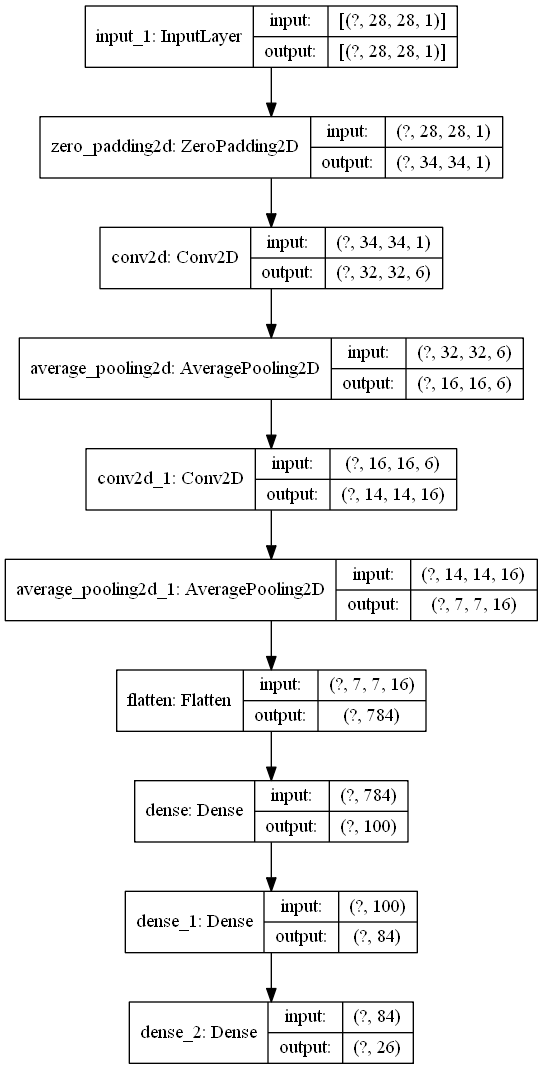

In [8]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [10]:
history = model.fit(X_train, y_train, 
                        epochs=50,
                        validation_split=0.2)

Train on 21963 samples, validate on 5491 samples
Epoch 1/50
21963/21963 [==============================] - 10s 461us/sample - loss: 3.1501 - accuracy: 0.0800 - val_loss: 2.9461 - val_accuracy: 0.1233
Epoch 2/50
21963/21963 [==============================] - 10s 436us/sample - loss: 2.3015 - accuracy: 0.2969 - val_loss: 2.0853 - val_accuracy: 0.3198
Epoch 3/50
21963/21963 [==============================] - 9s 432us/sample - loss: 1.4344 - accuracy: 0.5433 - val_loss: 1.4416 - val_accuracy: 0.5411
Epoch 4/50
21963/21963 [==============================] - 10s 442us/sample - loss: 0.9855 - accuracy: 0.6821 - val_loss: 0.7912 - val_accuracy: 0.7327
Epoch 5/50
21963/21963 [==============================] - 10s 434us/sample - loss: 0.7326 - accuracy: 0.7680 - val_loss: 0.9799 - val_accuracy: 0.6715
Epoch 6/50
21963/21963 [==============================] - 10s 439us/sample - loss: 0.5568 - accuracy: 0.8213 - val_loss: 0.7939 - val_accuracy: 0.7443
Epoch 7/50
21963/21963 [======================

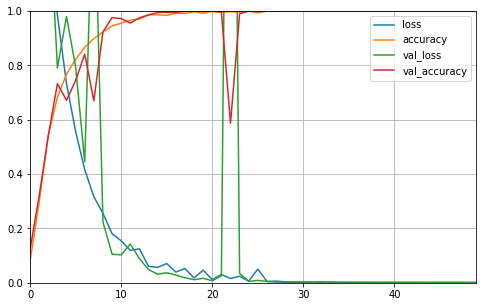

In [11]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

plt.show()

In [12]:
model.evaluate(X_test, y_test)

7171/7171 [==============================] - 1s 129us/sample - loss: 1.0090 - accuracy: 0.8559


[1.0089635361090412, 0.85594755]

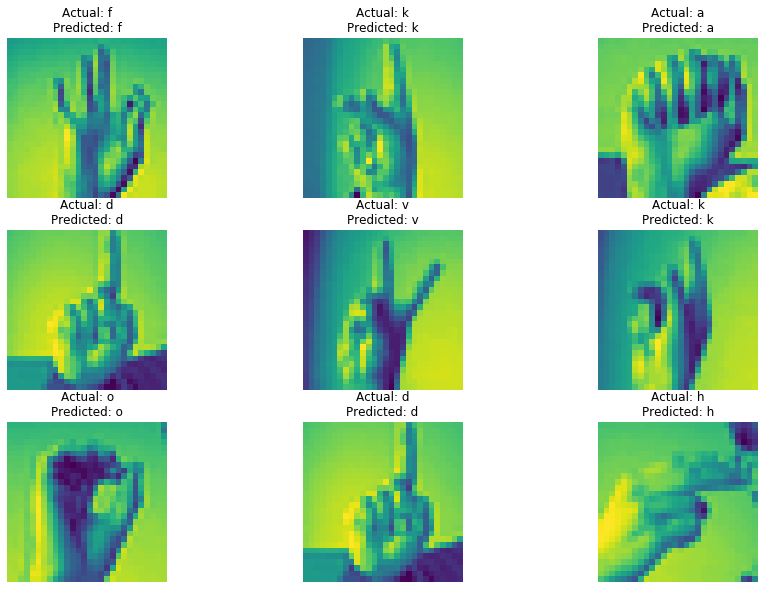

In [41]:
import math

num_rows = 3
num_cols = 3

X_new = X_test[:num_rows*num_cols]

y_pred = model.predict_classes(X_new)

fix, ax = plt.subplots(num_rows, num_cols)
for index, image in enumerate(X_new):
    ax[math.floor(index/num_rows), index%num_rows].imshow(image.reshape((28,28)))
    ax[math.floor(index/num_rows), index%num_rows].set_title(
        f"Actual: {class_names[y_test[index]]}\nPredicted: {class_names[y_pred[index]]}",
        fontsize=12)
    ax[int(index/num_rows), index%num_rows].axis('off')

fig.tight_layout()
fig.suptitle(f'First {num_cols*num_rows} Predictions')
fig.subplots_adjust(top=0.88)
fig.show()

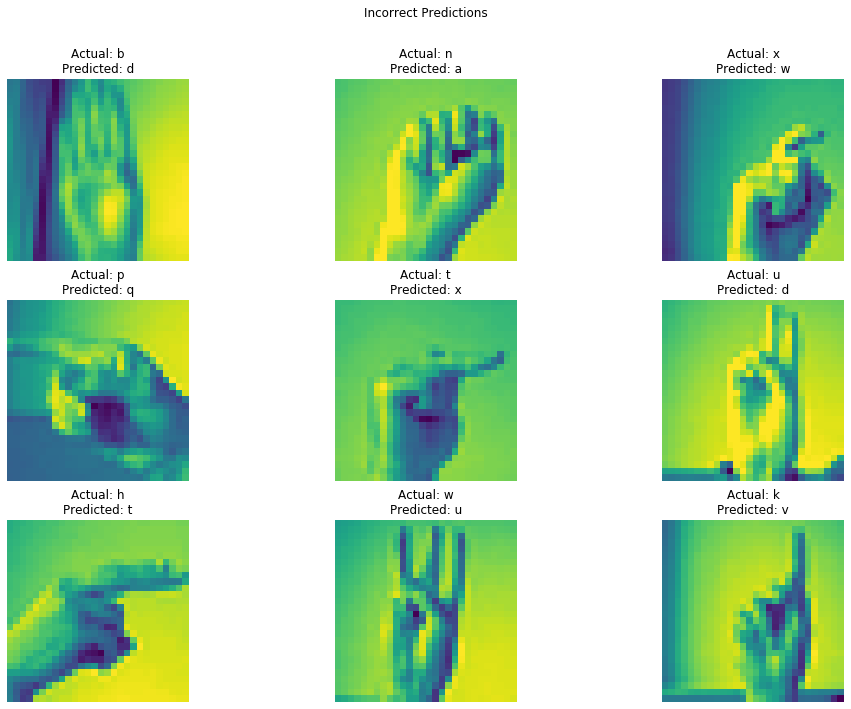

In [42]:
y_pred = model.predict_classes(X_test)

confusion_indices = np.where(y_pred != y_test)
X_confusion = X_test[confusion_indices]
y_pred_confusion = y_pred[confusion_indices]
y_test_confusion = y_test[confusion_indices]

fig, ax = plt.subplots(num_rows, num_cols)
for index, image in enumerate(X_confusion[:num_rows*num_cols]):
    ax[math.floor(index/num_rows), index%num_rows].imshow(image.reshape((28,28)))
    ax[math.floor(index/num_rows), index%num_rows].set_title(
        f"Actual: {class_names[y_test_confusion[index]]}\nPredicted: {class_names[y_pred_confusion[index]]}",
        fontsize=12)
    ax[int(index/num_rows), index%num_rows].axis('off')


fig.tight_layout()
fig.suptitle('Incorrect Predictions')
fig.subplots_adjust(top=0.88)
fig.show()

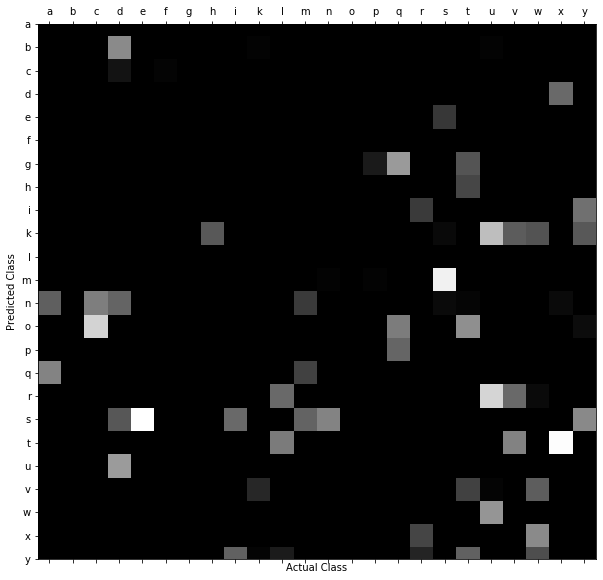

In [43]:
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
row_sum = confusion_matrix.sum(axis=1, keepdims=True)
norm_confusion_matrix = confusion_matrix / row_sum

# Becausse j and z aren't possible we cant include them in confusion matrix
class_names_clean = class_names.copy()
class_names_clean.remove('j')
class_names_clean.remove('z')

np.fill_diagonal(norm_confusion_matrix, 0)

plt.matshow(norm_confusion_matrix, cmap=plt.cm.gray)
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.xticks(ticks=np.arange(0, len(class_names_clean)), labels=class_names_clean)
plt.yticks(ticks=np.arange(0, len(class_names_clean)), labels=class_names_clean)
plt.show()


In [28]:
model.reset_metrics()
model.save('models/cnn_model_85_5.h5')